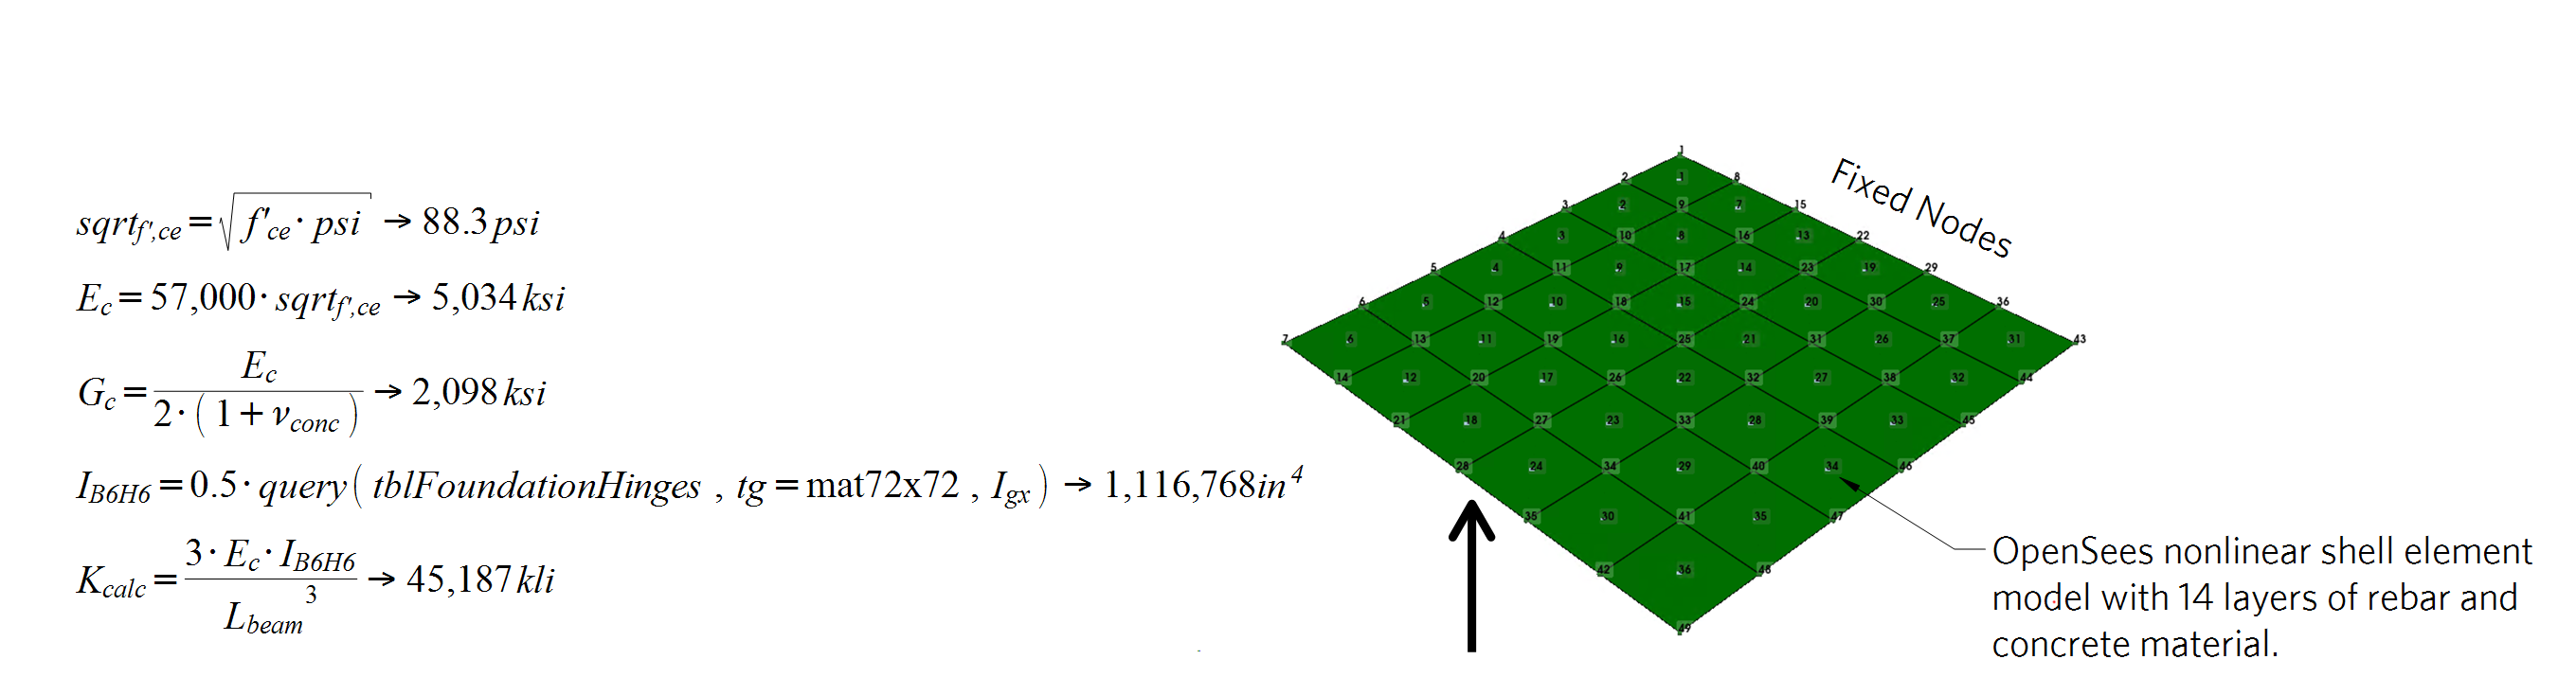

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import vfo.vfo as vfo
import openseespy.opensees as ops


def doPushover(ControlNode,ControlDOF,MaxDisp,fixedNodes,matElementTags):
    
    # create TimeSeries
    ops.timeSeries("Linear", 2)
    # create a plain load pattern
    ops.pattern("Plain", 2, 2)

    thisLoadPattern=[0,0,0,0,0,0]
    thisLoadPattern[ControlDOF-1]=1
    print("thisLoadPattern = ", thisLoadPattern)
    
    ops.load(ControlNode, *thisLoadPattern)
    
    # MaxDisp=20
    DispIncr=0.1
    NstepsPush=int(MaxDisp/DispIncr)
    
    ops.system("UmfPack")
    ops.numberer("RCM")
    ops.constraints("Plain")  # Transformation
    ops.test('NormDispIncr',1e-4, 1000)
    ops.integrator("DisplacementControl", ControlNode, ControlDOF, DispIncr)
    # ops.algorithm("Newton",'-initial')
    # ops.algorithm("NewtonLineSearch",'-RegulaFalsi')
    ops.algorithm('KrylovNewton','-initial')
   
    ops.analysis("Static")
    
    # Perform pushover analysis
    dataPush = np.zeros((NstepsPush,5))

    for j in range(NstepsPush-1):
        #print("step = ",j)
        ops.analyze(1)
        dataPush[j+1,0] = ops.nodeDisp(ControlNode,ControlDOF)
        ops.reactions()
        dataPush[j+1,1] = -1*sum([ops.nodeReaction(node,ControlDOF) for node in fixedNodes])
    
    print("Pushover analysis complete")

    return dataPush

In [7]:
ops.wipe()
# model and section
ops.model('basic', '-ndm', 3, '-ndf', 6)

"""
Out-of-plane bending test of a 72in x 72in sq, 72in deep concrete slab. 
The slab is modeled as a one-way cantilevered slab. The calculated stiffness is 45187 kips/in. 

"""

Lbeam=72 #inch
Bbeam=72 #inch
Tbeam=72 


concMatTag = 1
rebarMatTag = 2

concPSmatTag=3
concPlateTag = 4
plateRebarTag0 = 5
plateRebarTag90 = 6

####################
# Concrete
E_c = 5034
v_c=0.15
G_c=E_c/(2*(1+v_c))
K_c=E_c/(3*(1- 2*v_c))
sigInf=1.0*7.2
sig0=1.0*5.0

"""
Option 1 - Elastic concrete material provides the correct stiffness that matches the hand calculation. But, we want nonlinear behavior. 
"""
# ops.nDMaterial('ElasticIsotropic', concMatTag, 0.5*E_c, v_c)
# ops.nDMaterial('PlaneStress', concPSmatTag, concMatTag)

"""
Option 2 - ASDConcrete3D material results in a stiffness of about 22% of the exact solution. 
"""
# define a perfect bilinear behavior in tension and compression to record the failure surface
ey_c = sig0/E_c
ft = sig0/1000.0
et = ft/E_c
print("ey_c = ", ey_c)
ops.nDMaterial('ASDConcrete3D', concMatTag, 1.*E_c, v_c,
    '-Ce', 0.0, 0.00001*ey_c, 0.0024, 0.003, 0.009, 0.12,
    '-Cs', 0.0, sig0, sigInf, sigInf, 0.5*sig0, 0.5*sig0,
    '-Cd', 0.0, 0.0, 0.0, 0.0, 0,0,
    '-Te', 0.0, et, et+0.05, et+1,
    '-Ts', 0.0, ft, 0.8*ft, 0.8*ft,
    '-Td', 0.0, 0.0, 0.0, 0.0)
# ops.nDMaterial('PlaneStress', concPSmatTag, concMatTag)

"""
Option 3 - PSUMAT material results in a stiffness of about 22% of the exact solution. 
"""
                                                             #  fc,   ft,     fcu,    epsc0,   epscu,  epstu, stc)
ops.nDMaterial('PlaneStressUserMaterial', concPSmatTag, 40, 7, 7.2, 0.002, -0.2*7.2, -0.0025, -0.01, 0.001, 0.1)   # .2, 0.001, -0.2*7.2, -0.0047, -0.01, 0.001, 0.3
ops.nDMaterial('PlateFromPlaneStress',concPlateTag,concPSmatTag,1.0*E_c)


########################################
# Define material for 80 ksi rebar

Fye=85.0;		# Yield stress 
Fue=128.0
Es=29000.0;		# Modulus of Elasticity of Steel 

v=0.2;				# Poisson's ratio
Gs=Es/(2*(1+v));		# Shear modulus
b=0.02;				# Strain hardening ratio
R0=25.0
cR1=0.925
cR2=0.15
a1=0.05
a2=1.00
a3=0.05
a4=1.0

ops.uniaxialMaterial('Steel02', rebarMatTag, Fye, Es, b, R0, cR1, cR2, a1, a2, a3, a4)

# Convert rebar material to plane stress/plate rebar 
# Angle 0 is for vertical rebar and 90 is for horizontal rebar
ops.nDMaterial('PlateRebar',plateRebarTag0,rebarMatTag,0.0)
ops.nDMaterial('PlateRebar',plateRebarTag90,rebarMatTag,90.0)


#########################################
# Define LayeredShell section

secTagLS = 1

nLayers = 14
tRebar = 0.211667  # rebar layer thickness
tCover = 8
tMid = (Tbeam - (2*tCover + 4*tRebar))/(nLayers-6)

midLayers = 2*(nLayers-6)*[0]  # Creates an empty list of layers between the two rebar layers

jj=0

for ii,this in enumerate(midLayers):
    if ii%2 == 0:
        midLayers[ii]=concPlateTag
    else:
        midLayers[ii]=tMid
        jj+=1
    
matLayers = [concPlateTag,tCover,plateRebarTag0,tRebar,plateRebarTag90,tRebar]+\
            midLayers+[plateRebarTag90,tRebar,plateRebarTag0,tRebar,concPlateTag,tCover]

ops.section('LayeredShell',secTagLS, nLayers, *matLayers)

################
# mesh
################

Lx = Lbeam # Beam length
Ly = Bbeam    # Beam width
Nx = 6
Ny = 6
dLx = Lx/Nx
dLy = Ly/Ny

fixedNodes = []

for j in range(Ny+1):
	offset = j*(Nx+1)
	jY = j*dLy
	for i in range(Nx+1):
		iX = i*dLx
		_thisNodeID = offset+i+1
		ops.node(_thisNodeID, iX, jY, 0.0)
		if iX == 0:
			fixedNodes.append(_thisNodeID)
            
ele_id = 1
for j in range(Ny):
	for i in range(Nx):
		qids = (j*(Nx+1)+i+1, j*(Nx+1)+i+2, (j+1)*(Nx+1)+i+2, (j+1)*(Nx+1)+i+1)
		ops.element('ShellMITC4', ele_id, *qids, secTagLS)   #  ShellNLDKGQ    ASDShellQ4   ShellMITC4
		ele_id += 1

allElements = ops.getEleTags()
allNodes = ops.getNodeTags()

# fix
ops.fixX(0.0, 1,1,1,1,1,1)


################
## Push down
################

loadNode = (Nx+1)*(round(Ny/2)+1)

dataPush = doPushover(loadNode,3,1.5,fixedNodes,allElements)  # ControlNode,ControlDOF,MaxDisp

ops.wipe()


##########################
#  Compare output


K_OS= dataPush[1,1]/dataPush[1,0]  #kip/in
K_Etabs = 45918
print("stiff comparison: Etabs :", 45918, "vs OpenSees :", K_OS, " ratio of stiffness OS-Etabs :",K_OS/K_Etabs)

plt.plot([0,0.05],[0,K_Etabs*0.05],'b-^',label='Etabs')
plt.plot(dataPush[:-1,0], dataPush[:-1,1],'g-^',label='OpenSees')
# plt.xlim(0, 0.15)
# plt.ylim(0, 1000)
plt.grid(linestyle='dotted') 
plt.legend()
plt.xlabel('End Disp')
plt.ylabel('Base Shear (kip)')
plt.show()

ey_c =  0.0009932459276916965
thisLoadPattern =  [0, 0, 1, 0, 0, 0]
Pushover analysis complete


stiff comparison: Etabs : 45918 vs OpenSees : 10450.966664187377  ratio of stiffness OS-Etabs : 0.22760065038083926


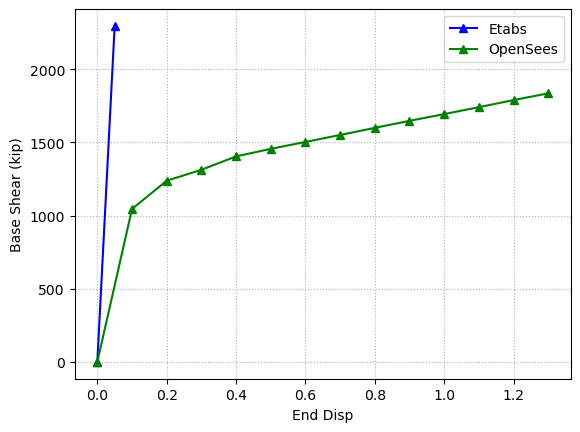